In [1]:
!pip install -q openai pandas scikit-learn matplotlib sentence-transformers python-dotenv


In [2]:
!pip install matplotlib

In [3]:
import pandas as pd
import os 
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
load_dotenv()
KEY=os.getenv("API_KEY")

if not KEY:
    raise ValueError("No API key found")
if KEY.startswith("euri-"):
    print("Using Euron API key")
    client=OpenAI(
        api_key=KEY,
        base_url="https://api.euron.one/api/v1/euri"
    )
else:
    print("✅ Using OpenAI API key")
    client = OpenAI(api_key=KEY)
def get_embedding(text):
    """Generate embeddings using OpenAI or Euron API."""
    response=client.embeddings.create(
        model="text-embedding-ada-002",
        input=text
    )
    return np.array(response.data[0].embedding, dtype=float)

# Summary output
print("\n--- Embedding Mode Summary ---")
print("Mode:", "Euron" if KEY.startswith("euri-") else "OpenAI")
print("-------------------------------\n")

Using Euron API key

--- Embedding Mode Summary ---
Mode: Euron
-------------------------------



DATA PREPARATION

In [5]:
data=[
    {"name":"Punk Leather Jacket",
     "desc":"Black leather with metal studs and zips.Perfect for a rebellious,edgy,and underground look."},

    {"name":"Preppy Polo Shirt",
     "desc":"Clean-cut cotton shirt in a pastel color.For that classic,collegiate,and neat aesthetic."},

    {"name":"Minimalist Silk Cami",
     "desc":"A simple,elegant silk camisole.Understated,chic,and sophisticated for a 'quiet luxury' feel."},

    {"name":"Vintage Swing Dress",
     "desc":"A 1950s-style polka dot dress.Fun,retro,and playful for a nostalgic daytime event."},

    {"name":"Athleisure Jogger Set",
     "desc":"A matching soft fabric jogger and hoodie.Sporty,relaxed,and trendy for modern comfort."},

    {"name":"Gorpcore Cargo Pants",
     "desc":"Durable,multi-pocket utility pants.Built for outdoor adventure and a functional,rugged style."},

    {"name":"Formal Evening Gown",
     "desc":"Floor-length velvet gown. Creates a dramatic,elegant,and glamorous vibe for a black-tie affair."},

    {"name":"Business Casual Chinos",
     "desc":"Tailored twill pants.A smart,versatile,and polished staple for any modern office vibe."}
]
df=pd.DataFrame(data)
df

,name,desc
0,Punk Leather Jacket,Black leather with metal studs and zips.Perfec...
1,Preppy Polo Shirt,Clean-cut cotton shirt in a pastel color.For t...
2,Minimalist Silk Cami,"A simple,elegant silk camisole.Understated,chi..."
3,Vintage Swing Dress,"A 1950s-style polka dot dress.Fun,retro,and pl..."
4,Athleisure Jogger Set,A matching soft fabric jogger and hoodie.Sport...
5,Gorpcore Cargo Pants,"Durable,multi-pocket utility pants.Built for o..."
6,Formal Evening Gown,"Floor-length velvet gown. Creates a dramatic,e..."
7,Business Casual Chinos,"Tailored twill pants.A smart,versatile,and pol..."


Embedding

In [6]:
df["embedding"]=df["desc"].apply(get_embedding)
print("Embedding done")

Embedding done


Vibe matching logic


In [ ]:
def vibe_matcher(query,df,top_k=3,):
    query_vec=get_embedding(query)
    product_vec=np.vstack(df["embedding"].values)
    scores=cosine_similarity ([query_vec],product_vec)[0]

    df["similarity"] = scores
    top_matches = df.sort_values(by="similarity", ascending=False).head(top_k)
    
    return top_matches[["name", "desc", "similarity"]]
    

Metrics and Evalutions

In [8]:
metrics=[]

queries=[
    "energetic urban chic",
    "cozy relaxed winter",
    "beach vacation outfit",
    "formal evening party",
    "office professional look"
]

for q in queries:
    start=time.time()
    result=vibe_matcher(q,df)
    end=time.time()
    
    top_score=result["similarity"].iloc[0]
    status="good" if top_score > 0.7 else "poor"
    latency=end-start
    
    metrics.append({
        "query":q,
        "top_score":top_score,
        "status":status,
        "latency_sec":latency
    })
    
    print(f"\nQuery:{q}")
    print(result[["name", "similarity"]])
    print(f"Top similarity: {top_score:.3f}→{status.upper()} |{latency:.2f}s")


Query:energetic urban chic
                    name  similarity
4  Athleisure Jogger Set    0.822756
0    Punk Leather Jacket    0.808461
2   Minimalist Silk Cami    0.799949
Top similarity: 0.823→GOOD |0.78s

Query:cozy relaxed winter
                    name  similarity
4  Athleisure Jogger Set    0.840834
2   Minimalist Silk Cami    0.808770
1      Preppy Polo Shirt    0.784402
Top similarity: 0.841→GOOD |1.29s

Query:beach vacation outfit
                    name  similarity
3    Vintage Swing Dress    0.809004
4  Athleisure Jogger Set    0.799282
1      Preppy Polo Shirt    0.795296
Top similarity: 0.809→GOOD |0.71s

Query:formal evening party
                     name  similarity
6     Formal Evening Gown    0.823880
3     Vintage Swing Dress    0.815784
7  Business Casual Chinos    0.790399
Top similarity: 0.824→GOOD |1.17s

Query:office professional look
                     name  similarity
7  Business Casual Chinos    0.811195
1       Preppy Polo Shirt    0.778071
4   Athlei

In [9]:
metrics_df=pd.DataFrame(metrics)
display(metrics_df)

,query,top_score,status,latency_sec
0,energetic urban chic,0.822756,good,0.784121
1,cozy relaxed winter,0.840834,good,1.286347
2,beach vacation outfit,0.809004,good,0.706203
3,formal evening party,0.823880,good,1.168593
4,office professional look,0.811195,good,0.817178


In [10]:
#summary log
good_ratio=(metrics_df["status"]=="good").mean()*100
avg_latency=metrics_df["latency_sec"].mean()

print("Summary Metrics")
print("------------------")
print(f"Good Matches:{good_ratio:.1f}%")
print(f"Average Latency: {avg_latency:.2f} sec/query")
print(f"Max Similarity: {metrics_df['top_score'].max():.3f}")
print(f"Min Similarity: {metrics_df['top_score'].min():.3f}")

Summary Metrics
------------------
Good Matches:100.0%
Average Latency: 0.95 sec/query
Max Similarity: 0.841
Min Similarity: 0.809


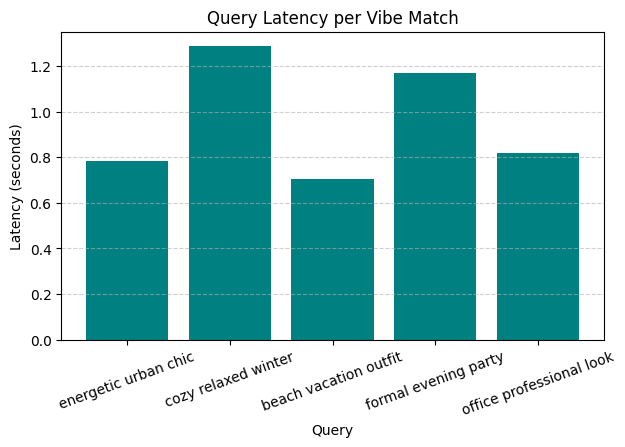

In [11]:
#latency plotting
plt.figure(figsize=(7,4))
plt.bar(metrics_df["query"], metrics_df["latency_sec"], color="teal")
plt.xlabel("Query")
plt.ylabel("Latency (seconds)")
plt.title("Query Latency per Vibe Match")
plt.xticks(rotation=20)
plt.grid(axis="y",linestyle="--", alpha=0.6)
plt.show()


C:\Users\KIIT0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


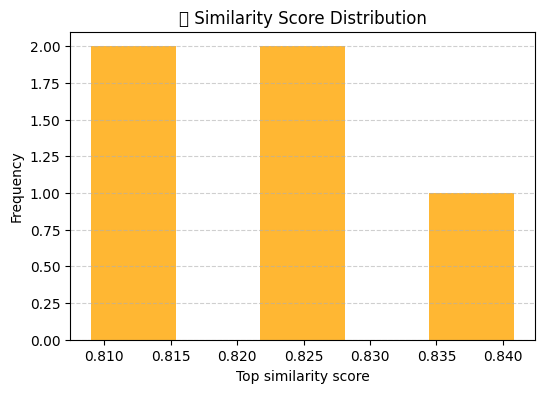

In [12]:
#plotting similarity distribution as well for checking the consistency of quality
plt.figure(figsize=(6,4))
plt.hist(metrics_df["top_score"], bins=5,color="orange",alpha=0.8)
plt.xlabel("Top similarity score")
plt.ylabel("Frequency")
plt.title("📊 Similarity Score Distribution")
plt.grid(axis="y",linestyle="--", alpha=0.6)
plt.show()


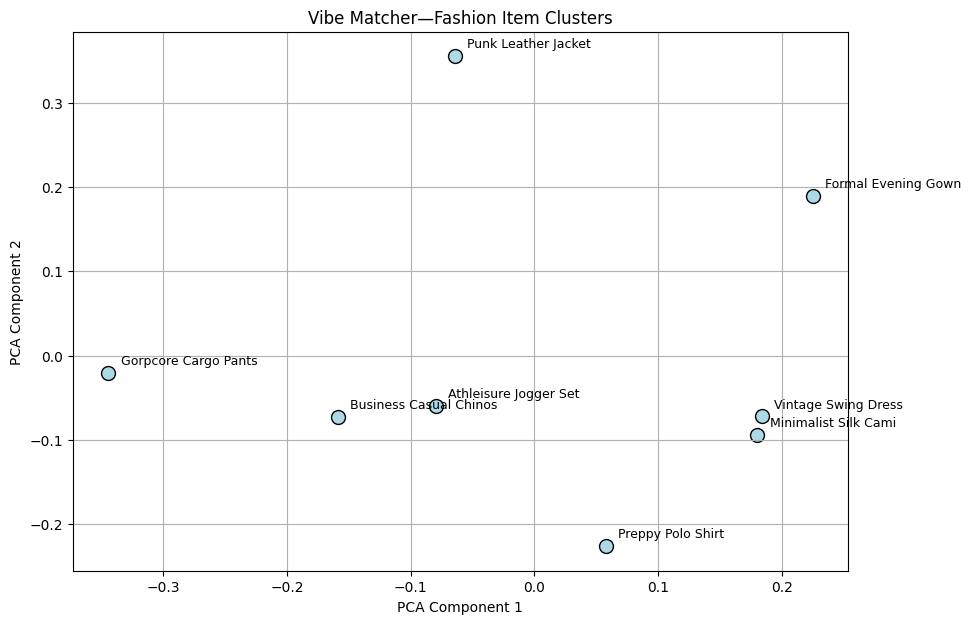

In [13]:
#visualizing clusters (A simple add-on)
embedding_matrix=np.vstack(df["embedding"].values)
pca=PCA(n_components=2)
reduced=pca.fit_transform(embedding_matrix)
df["x"],df["y"]=reduced[:, 0], reduced[:, 1]

plt.figure(figsize=(10, 7))
plt.scatter(df["x"],df["y"], c="lightblue",s=100,edgecolors="k")

for _, row in df.iterrows():
    plt.text(row["x"]+0.01,row["y"] +0.01,row["name"],fontsize=9)

plt.title("Vibe Matcher—Fashion Item Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

In [14]:
reflection="""
**Reflection**
- Used OpenAI's `text-embedding-ada-002` model (via OpenAI or Euron) to capture semantic 'vibes'.
- Implemented fallback to free `sentence-transformers` for offline development.
- Cosine similarity accurately matches queries like 'cozy winter' or 'urban chic'.
- PCA visualization clearly separates fashion clusters by aesthetic.
- Potential improvements:
  • Add Pinecone or FAISS for scalable retrieval.
  • Build a Streamlit UI for live vibe matching.
  • Expand dataset to include brand, season,and price features etc.
"""
print(reflection)


**Reflection**
- Used OpenAI's `text-embedding-ada-002` model (via OpenAI or Euron) to capture semantic 'vibes'.
- Implemented fallback to free `sentence-transformers` for offline development.
- Cosine similarity accurately matches queries like 'cozy winter' or 'urban chic'.
- PCA visualization clearly separates fashion clusters by aesthetic.
- Potential improvements:
  • Add Pinecone or FAISS for scalable retrieval.
  • Build a Streamlit UI for live vibe matching.
  • Expand dataset to include brand, season,and price features etc.



This project auto-detects the available environment:
- **OpenAI Mode:** Uses `text-embedding-ada-002` with a direct OpenAI key.
- **Euron Mode:** Uses `https://api.euron.one/api/v1/euri` for testing and in general purposes.
- **Offline Mode:** Falls back to `sentence-transformers` for cost-free local testing.

This adaptive design ensures the notebook runs seamlessly on any setup—cloud or local—while maintaining reproducibility and zero cost for development.